In [ ]:
# connect google drive folder if using colab, gpu will be needed for gpu enabled models

from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/SMU_MITB_NLP/project/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/SMU_MITB_NLP/project


In [1]:
# run cell to read file from data if using colab

import pandas as pd
labelled_sentences = pd.read_excel('FOMC Labelled Sentences.xlsx')
statements = pd.read_excel('FOMC Statements 1997-2023.xlsx')

FileNotFoundError: [Errno 2] No such file or directory: 'FOMC Labelled Sentences.xlsx'

In [2]:
# run cell if using from local/github

import pandas as pd
# read file from data
labelled_sentences = pd.read_excel('data/FOMC Labelled Sentences.xlsx')
statements = pd.read_excel('data/FOMC Statements 1997-2023.xlsx')

In [3]:
labelled_sentences.head()

# remove row if score contains 'Remove'
labelled_sentences = labelled_sentences[labelled_sentences['Score'] != 'Remove']
labelled_sentences.shape

class_counts = labelled_sentences['Score'].value_counts()
print(class_counts)

 0.0    57
-1.0    42
 0.5    36
 1.0    32
-0.5    21
Name: Score, dtype: int64


In [7]:
!pip install nlpaug # needed if using colab, else skip

     ------------------------------------- 410.5/410.5 kB 12.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [4]:
import nlpaug.augmenter.char as nac
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.sentence as nas
import nlpaug.flow as nafc
from gensim.models import KeyedVectors

In [5]:
# leave out 20% of the data for testing
from sklearn.model_selection import train_test_split

# only keep sentence and score columns


labelled_sentences = labelled_sentences[['Sentence', 'Score']]

train, test = train_test_split(labelled_sentences, test_size=0.2, random_state=23, stratify=labelled_sentences['Score'])

class_counts_train = train['Score'].value_counts()
class_counts_test = test['Score'].value_counts()
# Print the counts
print(class_counts_train)
print(class_counts_test)

 0.0    45
-1.0    33
 0.5    29
 1.0    26
-0.5    17
Name: Score, dtype: int64
 0.0    12
-1.0     9
 0.5     7
 1.0     6
-0.5     4
Name: Score, dtype: int64


In [6]:
# Function to create new dataframe with augmented data and label by providing augmenter

def augment_dataset(data, augmenter, num_augmented=2):
    data_augmented = data.copy()
    augmented_data = []

    for index, row in data_augmented.iterrows():
        for _ in range(num_augmented):
            augmented_data.append([ ' '.join(augmenter.augment(row['Sentence'])), row['Score']])

    augmented_data_df = pd.DataFrame(augmented_data, columns=['Sentence', 'Score'])

    return augmented_data_df

def combine_datasets(original_data, augmented_data):
    # Combine the original dataset and the augmented dataset into a single dataframe
    combined_data = pd.concat([original_data, augmented_data], ignore_index=True)
    
    return combined_data

In [7]:
aug = naw.SynonymAug(aug_src='wordnet')
augmented_data = augment_dataset(train, aug)
augmented_data

,Sentence,Score
0,"Inflation has picked upward in late months, pr...",1.0
1,Ostentatiousness get picked upward in recent m...,1.0
2,The ongoing public wellness crisis continues t...,-1.0
3,The on going public wellness crisis continues ...,-1.0
4,_x000D_ _x000D_ Although the necessary realloc...,0.5
...,...,...
295,"In contrast, the probability, though minor, of...",-1.0
296,"The Committee expects that, with appropriate p...",0.5
297,"The Committee expects that, with appropriate i...",0.5
298,The Federal Reserve is prepare to modify these...,-0.5


In [8]:
train_augmented = combine_datasets(train, augmented_data)
train_augmented

,Sentence,Score
0,"Inflation has picked up in recent months, main...",1
1,The ongoing public health crisis continues to ...,-1
2,_x000D_\n_x000D_\nAlthough the necessary reall...,0.5
3,Recent developments are likely to result in ti...,-1
4,In determining the timing and size of future a...,0
...,...,...
445,"In contrast, the probability, though minor, of...",-1.0
446,"The Committee expects that, with appropriate p...",0.5
447,"The Committee expects that, with appropriate i...",0.5
448,The Federal Reserve is prepare to modify these...,-0.5


# RNN

In [ ]:
# !pip install keras-self-attention # needed if using colab, else skip

In [ ]:
# RNN

import pandas as pd
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Bidirectional, SimpleRNN, LeakyReLU, Dropout, MultiHeadAttention, Flatten
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras_self_attention import SeqSelfAttention
from sklearn.model_selection import train_test_split

In [ ]:
"""
RNN Modelling - 

Data is first processed using the process_sentences function
Tokenizer is created and fit on the training and development sentences
Additional preprocessing to ensure the parameters and formats are right
Sequential model is created with multiple layers - and to be tested with different layers and parameters
Model is compiled with binary_crossentropy loss function for binary classification
"""

x_train, x_test, y_train, y_test = train_test_split(labelled_sentences['Sentence'], labelled_sentences['Score'], test_size=0.2, random_state=23)

class_mapping = {-1: 0, -0.5: 1, 0: 2, 0.5: 3, 1: 4}
n_classes = len(class_mapping.keys())
y_train = y_train.map(class_mapping)
y_test = y_test.map(class_mapping)

# Tokenize the sentences
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(x_train)

train_sequences = tokenizer.texts_to_sequences(x_train)
test_sequences = tokenizer.texts_to_sequences(x_test)

# Find the maximum sequence length
max_length = max(max(len(seq) for seq in train_sequences), max(len(seq) for seq in test_sequences))

train_sequences = pad_sequences(train_sequences, maxlen=max_length, padding='post')
test_sequences = pad_sequences(test_sequences, maxlen=max_length, padding='post')

# Define the vocabulary size
vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index for padding

# Create a Sequential model, tested many different layers and parameters
# model = Sequential()
# model.add(Embedding(vocab_size, 50, input_length=max_length))
# model.add(Bidirectional(LSTM(50, return_sequences=True)))
# model.add(Bidirectional(LSTM(50)))
# model.add(Dense(1, activation='sigmoid'))

# model = Sequential()
# model.add(Embedding(vocab_size, 50, input_length=max_length))
# model.add(SimpleRNN(units=32))
# model.add(LeakyReLU(alpha=0.01))
# model.add(Dropout(0.5))
# model.add(Dense(1, activation='sigmoid'))

model = Sequential()
model.add(Embedding(vocab_size, 30, input_length=max_length))
model.add(Bidirectional(LSTM(30, return_sequences=True)))
model.add(Bidirectional(LSTM(30, return_sequences=True)))
model.add(Bidirectional(LSTM(30)))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(n_classes, activation='softmax'))

# model = Sequential()
# model.add(Embedding(vocab_size, 50, input_length=max_length))
# model.add(Bidirectional(LSTM(units=16, return_sequences=True, dropout=0.5, recurrent_dropout=0.7)))
# model.add(SeqSelfAttention(attention_activation='sigmoid'))
# model.add(Flatten())
# model.add(Dense(1, activation='sigmoid'))

# Compile the model for multi-class classification
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=6) # stop the training process, for example if the validation loss doesn't decrease for 2 consecutive epochs (patience=2). to prevent overfitting

# Include early stopping in the model fit
rnn = model.fit(train_sequences, y_train, epochs=20, validation_data=(test_sequences, y_test))#, callbacks=[early_stopping])
rnn

Epoch 1/20
5/5 [==============================] - 16s 954ms/step - loss: 1.6003 - accuracy: 0.3067 - val_loss: 1.6049 - val_accuracy: 0.1579
Epoch 2/20
5/5 [==============================] - 1s 231ms/step - loss: 1.5698 - accuracy: 0.3400 - val_loss: 1.6165 - val_accuracy: 0.1579
Epoch 3/20
5/5 [==============================] - 1s 175ms/step - loss: 1.5582 - accuracy: 0.3400 - val_loss: 1.6829 - val_accuracy: 0.1579
Epoch 4/20
5/5 [==============================] - 1s 209ms/step - loss: 1.5404 - accuracy: 0.3400 - val_loss: 1.6452 - val_accuracy: 0.1579
Epoch 5/20
5/5 [==============================] - 1s 235ms/step - loss: 1.5362 - accuracy: 0.3400 - val_loss: 1.6254 - val_accuracy: 0.1579
Epoch 6/20
5/5 [==============================] - 1s 190ms/step - loss: 1.5292 - accuracy: 0.3400 - val_loss: 1.6341 - val_accuracy: 0.1579
Epoch 7/20
5/5 [==============================] - 1s 104ms/step - loss: 1.5169 - accuracy: 0.3400 - val_loss: 1.6501 - val_accuracy: 0.1579
Epoch 8/20
5/5 [===

In [ ]:
"""
RNN Modelling - 

Data is first processed using the process_sentences function
Tokenizer is created and fit on the training and development sentences
Additional preprocessing to ensure the parameters and formats are right
Sequential model is created with multiple layers - and to be tested with different layers and parameters
Model is compiled with binary_crossentropy loss function for binary classification
"""

x_train, x_test, y_train, y_test = train_test_split(train_augmented['Sentence'], train_augmented['Score'], test_size=0.2, random_state=23)

class_mapping = {-1: 0, -0.5: 1, 0: 2, 0.5: 3, 1: 4}
n_classes = len(class_mapping.keys())
y_train = y_train.map(class_mapping)
y_test = y_test.map(class_mapping)

# Tokenize the sentences
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(x_train)

train_sequences = tokenizer.texts_to_sequences(x_train)
test_sequences = tokenizer.texts_to_sequences(x_test)

# Find the maximum sequence length
max_length = max(max(len(seq) for seq in train_sequences), max(len(seq) for seq in test_sequences))

train_sequences = pad_sequences(train_sequences, maxlen=max_length, padding='post')
test_sequences = pad_sequences(test_sequences, maxlen=max_length, padding='post')

# Define the vocabulary size
vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index for padding

# Create a Sequential model, tested many different layers and parameters
# model = Sequential()
# model.add(Embedding(vocab_size, 50, input_length=max_length))
# model.add(Bidirectional(LSTM(50, return_sequences=True)))
# model.add(Bidirectional(LSTM(50)))
# model.add(Dense(1, activation='sigmoid'))

# model = Sequential()
# model.add(Embedding(vocab_size, 50, input_length=max_length))
# model.add(SimpleRNN(units=32))
# model.add(LeakyReLU(alpha=0.01))
# model.add(Dropout(0.5))
# model.add(Dense(1, activation='sigmoid'))

model = Sequential()
model.add(Embedding(vocab_size, 30, input_length=max_length))
model.add(Bidirectional(LSTM(30, return_sequences=True)))
model.add(Bidirectional(LSTM(30, return_sequences=True)))
model.add(Bidirectional(LSTM(30)))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(n_classes, activation='softmax'))

# model = Sequential()
# model.add(Embedding(vocab_size, 50, input_length=max_length))
# model.add(Bidirectional(LSTM(units=16, return_sequences=True, dropout=0.5, recurrent_dropout=0.7)))
# model.add(SeqSelfAttention(attention_activation='sigmoid'))
# model.add(Flatten())
# model.add(Dense(1, activation='sigmoid'))

# Compile the model for multi-class classification
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=6) # stop the training process, for example if the validation loss doesn't decrease for 2 consecutive epochs (patience=2). to prevent overfitting

# Include early stopping in the model fit
rnn = model.fit(train_sequences, y_train, epochs=20, validation_data=(test_sequences, y_test))#, callbacks=[early_stopping])
rnn

Epoch 1/20
12/12 [==============================] - 13s 282ms/step - loss: 1.5962 - accuracy: 0.3222 - val_loss: 1.5585 - val_accuracy: 0.3556
Epoch 2/20
12/12 [==============================] - 1s 101ms/step - loss: 1.5605 - accuracy: 0.3361 - val_loss: 1.5215 - val_accuracy: 0.3556
Epoch 3/20
12/12 [==============================] - 1s 115ms/step - loss: 1.5078 - accuracy: 0.3361 - val_loss: 1.4556 - val_accuracy: 0.3556
Epoch 4/20
12/12 [==============================] - 1s 127ms/step - loss: 1.3563 - accuracy: 0.3556 - val_loss: 1.3527 - val_accuracy: 0.4667
Epoch 5/20
12/12 [==============================] - 1s 120ms/step - loss: 1.1635 - accuracy: 0.4750 - val_loss: 1.1564 - val_accuracy: 0.5111
Epoch 6/20
12/12 [==============================] - 2s 135ms/step - loss: 1.0956 - accuracy: 0.5278 - val_loss: 1.1026 - val_accuracy: 0.5444
Epoch 7/20
12/12 [==============================] - 1s 120ms/step - loss: 0.9702 - accuracy: 0.6361 - val_loss: 1.0242 - val_accuracy: 0.5000
Epoch

In [ ]:
# Assuming your original test sentences are in a pandas DataFrame column named 'Sentence'
# Tokenize the test sentences
test_sequences_original = tokenizer.texts_to_sequences(test['Sentence'])

# Pad the sequences
test_sequences_original = pad_sequences(test_sequences_original, maxlen=max_length, padding='post')

# Predict class probabilities for the test set
y_pred_prob = model.predict(test_sequences_original)

# Select the class with the highest probability as the predicted class
y_pred = np.argmax(y_pred_prob, axis=1)

inverse_class_mapping = {v: k for k, v in class_mapping.items()}

# Inverse map the classes to their original values
y_pred = np.vectorize(inverse_class_mapping.get)(y_pred)

y_test_original = test['Score']

accuracy = np.mean(y_pred == y_test_original.values)

print(f'Accuracy: {accuracy*100:.2f}%')
print(y_pred)
print(y_test_original.values)


2/2 [==============================] - 0s 20ms/step
Accuracy: 42.11%
[ 1 -1  0  1 -1 -1 -1  1  1  0  1  0 -1  1  0  0  0 -1 -1  0  1  0  0  0
  0  0  1  0  1  1  1  0  1  1  1 -1  1 -1]
[1 -1 1 1 -1 -1 -1 0.5 0.5 1 0.5 -1 -1 0.5 0 0.5 -0.5 0.5 1 -0.5 1 0.5 0 0
 -1 0.5 -1 0 1 -1 1 -0.5 -1 1 1 0 -1 0]


In [ ]:
test

,Sentence,Score
16,But domestic financial markets have recovered ...,1
188,The Committee will continue its purchases of T...,-1
198,In light of the substantial further progress t...,1
179,"Job gains have been solid in recent months, an...",1
95,"In a related action, the Board of Governors un...",-1
145,\nThe Federal Reserve is committed to using it...,-1
174,The possibility that this excess could continu...,-1
21,"However, a sustained moderation in inflation p...",0.5
64,"However, the Committee judges that some inflat...",0.5
80,\nInformation received since the Federal Open ...,1


# BERT

In [ ]:
!pip install --upgrade transformers # run this cell if using notebook in colab 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 53.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 91.8 MB/s eta 0:00:00


In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.utils import pad_sequences
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup, RobertaForSequenceClassification, RobertaTokenizer
import pandas as pd
import numpy as np

In [ ]:
# Check if GPU is available and if not, use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

def tokenize(sentences, tokenizer, max_length):
    """
    Function to ensure the input is formatted correctly such as tokenization, length, padding and attention
    """
    input_ids = []
    attention_masks = []
    for sent in sentences:
        encoded_dict = tokenizer.encode_plus(
            sent,
            add_special_tokens=True,
            max_length=max_length,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )
        if encoded_dict['input_ids'].size()[1] > max_length:
            encoded_dict['input_ids'] = encoded_dict['input_ids'][:, :max_length]
            encoded_dict['attention_mask'] = encoded_dict['attention_mask'][:, :max_length]

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    return input_ids, attention_masks

x_train, x_test, y_train, y_test = train_test_split(labelled_sentences['Sentence'], labelled_sentences['Score'], test_size=0.2, random_state=23)

score_mapping = {-1: 0, -0.5: 1, 0: 2, 0.5: 3, 1: 4}
n_classes = len(score_mapping)

y_train = y_train.map(score_mapping)
y_test = y_test.map(score_mapping)

# Tokenize both training and validation sentences
train_input_ids, train_attention_mask = tokenize(x_train.values.tolist(), tokenizer, max_length=64)
dev_input_ids, dev_attention_mask = tokenize(x_test.values.tolist(), tokenizer, max_length=64)

# Convert the lists into tensors.
train_labels = torch.tensor(y_train.values)
dev_labels = torch.tensor(y_test.values)

# Create the DataLoader for training set
train_data = TensorDataset(train_input_ids, train_attention_mask, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=32)

# Create the DataLoader for dev set
dev_data = TensorDataset(dev_input_ids, dev_attention_mask, dev_labels)
dev_sampler = SequentialSampler(dev_data)
dev_dataloader = DataLoader(dev_data, sampler=dev_sampler, batch_size=32)

# Load BertForSequenceClassification, adjust num_labels to your classification task
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", 
    num_labels = n_classes,
    output_attentions = False, 
    output_hidden_states = False
)
model.to(device)

# Create the optimizer
optimizer = AdamW(model.parameters(),
                  lr = 5e-5, # learning rate
                  eps = 1e-8
                )

epochs = 16 # number of epochs
total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, 
                                            num_training_steps = total_steps)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
import random
import time
import datetime

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# Function to format time
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

# Training loop
for epoch_i in range(0, epochs):
    print('\n======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    model.train()

    # For each batch of training data
    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()        

        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask, 
                        labels=b_labels)

        loss = outputs.loss

        total_train_loss += loss.item()

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    print("\n  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(format_time(time.time() - t0)))

    # Validation
    t0 = time.time()

    model.eval()

    total_eval_accuracy = 0
    total_eval_loss = 0

    for batch in dev_dataloader:

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():        
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask,
                            labels=b_labels)
            
        loss = outputs.loss
        logits = outputs.logits

        total_eval_loss += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        total_eval_accuracy += flat_accuracy(logits, label_ids)

    avg_val_accuracy = total_eval_accuracy / len(dev_dataloader)
    print("\n  Accuracy: {0:.2f}".format(avg_val_accuracy))

    avg_val_loss = total_eval_loss / len(dev_dataloader)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("\nTraining complete!")


======== Epoch 1 / 16 ========

  Average training loss: 1.61
  Training epoch took: 0:00:02

  Accuracy: 0.24
  Validation Loss: 1.62
  Validation took: 0:00:00

======== Epoch 2 / 16 ========

  Average training loss: 1.49
  Training epoch took: 0:00:02

  Accuracy: 0.18
  Validation Loss: 1.54
  Validation took: 0:00:00

======== Epoch 3 / 16 ========

  Average training loss: 1.37
  Training epoch took: 0:00:01

  Accuracy: 0.41
  Validation Loss: 1.51
  Validation took: 0:00:00

======== Epoch 4 / 16 ========

  Average training loss: 1.26
  Training epoch took: 0:00:01

  Accuracy: 0.37
  Validation Loss: 1.51
  Validation took: 0:00:00

======== Epoch 5 / 16 ========

  Average training loss: 1.13
  Training epoch took: 0:00:02

  Accuracy: 0.35
  Validation Loss: 1.52
  Validation took: 0:00:00

======== Epoch 6 / 16 ========

  Average training loss: 1.01
  Training epoch took: 0:00:02

  Accuracy: 0.45
  Validation Loss: 1.44
  Validation took: 0:00:00

======== Epoch 7 / 16

In [ ]:
test_input_ids, test_attention_mask = tokenize(x_test.values.tolist(), tokenizer, max_length=64)



# Create the DataLoader for test set
test_data = TensorDataset(test_input_ids, test_attention_mask)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=32)

print("Running Testing...")

t0 = time.time()

# Put the model in evaluation mode
model.eval()

# List to store predictions
test_predictions = []

# Evaluate data for one epoch
for batch in test_dataloader:
    
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    
    with torch.no_grad():        

        # Forward pass, calculate logit predictions.
        output = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask)
        logits = output.logits
        
    # Move logits to CPU
    logits = logits.detach().cpu().numpy()

    # Store predictions
    test_predictions.extend(np.argmax(logits, axis=1))

# Measure how long the testing run took.
testing_time = format_time(time.time() - t0)

print("Testing took: {:}".format(testing_time))

Running Testing...
Testing took: 0:00:00


In [ ]:
# Store predictions with labels starting from 1
test_predictions_bert = [prediction+1 for prediction in test_predictions]

# Print predictions
print("Predictions:", test_predictions_bert)

Predictions: [5, 3, 5, 5, 1, 1, 1, 1, 2, 4, 3, 4, 1, 1, 3, 4, 1, 4, 3, 4, 5, 4, 4, 4, 4, 1, 4, 3, 5, 1, 4, 4, 1, 1, 5, 3, 1, 4]


# ROBERTA

In [ ]:
# Check if GPU is available and if not, use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the BERT tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base', do_lower_case=True)

def tokenize(sentences, tokenizer, max_length):
    """
    Function to ensure the input is formatted correctly such as tokenization, length, padding and attention
    """
    input_ids = []
    attention_masks = []
    for sent in sentences:
        encoded_dict = tokenizer.encode_plus(
            sent,
            add_special_tokens=True,
            max_length=max_length,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )
        if encoded_dict['input_ids'].size()[1] > max_length:
            encoded_dict['input_ids'] = encoded_dict['input_ids'][:, :max_length]
            encoded_dict['attention_mask'] = encoded_dict['attention_mask'][:, :max_length]

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    return input_ids, attention_masks

x_train, x_test, y_train, y_test = train_test_split(labelled_sentences['Sentence'], labelled_sentences['Score'], test_size=0.2, random_state=23)

score_mapping = {-1: 0, -0.5: 1, 0: 2, 0.5: 3, 1: 4}
n_classes = len(score_mapping)

y_train = y_train.map(score_mapping)
y_test = y_test.map(score_mapping)

# Tokenize both training and validation sentences
train_input_ids, train_attention_mask = tokenize(x_train.values.tolist(), tokenizer, max_length=100)
dev_input_ids, dev_attention_mask = tokenize(x_test.values.tolist(), tokenizer, max_length=100)

# Convert the lists into tensors.
train_labels = torch.tensor(y_train.values)
dev_labels = torch.tensor(y_test.values)

# Create the DataLoader for training set
train_data = TensorDataset(train_input_ids, train_attention_mask, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=32)

# Create the DataLoader for dev set
dev_data = TensorDataset(dev_input_ids, dev_attention_mask, dev_labels)
dev_sampler = SequentialSampler(dev_data)
dev_dataloader = DataLoader(dev_data, sampler=dev_sampler, batch_size=32)

# Load RobertaForSequenceClassification
model = RobertaForSequenceClassification.from_pretrained(
    "roberta-base", 
    num_labels = n_classes,
    output_attentions = False, 
    output_hidden_states = False
)
model.to(device)

# Create the optimizer
optimizer = AdamW(model.parameters(),
                  lr = 5e-5, # learning rate
                  eps = 1e-8
                )

epochs = 16 # number of epochs
total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, 
                                            num_training_steps = total_steps)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

In [ ]:
import random
import time
import datetime

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# Function to format time
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

# Training loop
for epoch_i in range(0, epochs):
    print('\n======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    model.train()

    # For each batch of training data
    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()        

        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask, 
                        labels=b_labels)

        loss = outputs.loss

        total_train_loss += loss.item()

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    print("\n  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(format_time(time.time() - t0)))

    # Validation
    t0 = time.time()

    model.eval()

    total_eval_accuracy = 0
    total_eval_loss = 0

    for batch in dev_dataloader:

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():        
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask,
                            labels=b_labels)
            
        loss = outputs.loss
        logits = outputs.logits

        total_eval_loss += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        total_eval_accuracy += flat_accuracy(logits, label_ids)

    avg_val_accuracy = total_eval_accuracy / len(dev_dataloader)
    print("\n  Accuracy: {0:.2f}".format(avg_val_accuracy))

    avg_val_loss = total_eval_loss / len(dev_dataloader)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("\nTraining complete!")


======== Epoch 1 / 16 ========

  Average training loss: 1.60
  Training epoch took: 0:00:03

  Accuracy: 0.23
  Validation Loss: 1.60
  Validation took: 0:00:00

======== Epoch 2 / 16 ========

  Average training loss: 1.51
  Training epoch took: 0:00:03

  Accuracy: 0.23
  Validation Loss: 1.71
  Validation took: 0:00:00

======== Epoch 3 / 16 ========

  Average training loss: 1.48
  Training epoch took: 0:00:03

  Accuracy: 0.34
  Validation Loss: 1.57
  Validation took: 0:00:00

======== Epoch 4 / 16 ========

  Average training loss: 1.32
  Training epoch took: 0:00:03

  Accuracy: 0.32
  Validation Loss: 1.57
  Validation took: 0:00:00

======== Epoch 5 / 16 ========

  Average training loss: 1.15
  Training epoch took: 0:00:03

  Accuracy: 0.42
  Validation Loss: 1.49
  Validation took: 0:00:00

======== Epoch 6 / 16 ========

  Average training loss: 0.98
  Training epoch took: 0:00:03

  Accuracy: 0.50
  Validation Loss: 1.46
  Validation took: 0:00:00

======== Epoch 7 / 16

In [ ]:
# Assuming test_sentences are in a pandas DataFrame column named 'Sentence'
# Tokenize the test sentences
test_input_ids, test_attention_mask = tokenize(test['Sentence'].values.tolist(), tokenizer, max_length=100)

# Convert inputs to tensors
test_inputs = torch.tensor(test_input_ids)
test_masks = torch.tensor(test_attention_mask)

# Create DataLoader for the test data
batch_size = 32

test_data = TensorDataset(test_inputs, test_masks)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

model.eval()

predicted_scores = []

for batch in test_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask = batch

    with torch.no_grad():
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
        
    logits = outputs[0]

    logits = logits.detach().cpu().numpy()

    predicted_scores.extend(np.argmax(logits, axis=1).flatten())

inverse_class_mapping = {v: k for k, v in score_mapping.items()}

# Inverse map the classes to their original values
predicted_scores = np.vectorize(inverse_class_mapping.get)(predicted_scores)

accuracy = np.mean(predicted_scores == test['Score'].values)
print(f'Test Accuracy: {accuracy*100:.2f}%')

<ipython-input-45-96255f1895ed>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_inputs = torch.tensor(test_input_ids)
<ipython-input-45-96255f1895ed>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_masks = torch.tensor(test_attention_mask)


Test Accuracy: 60.53%


In [ ]:
# Add the original sentences and their predicted scores to a DataFrame
predictions_df = pd.DataFrame({'Sentence': test['Sentence'], 'Predicted_Score': predicted_scores})

# Print the DataFrame
print(predictions_df)

                                              Sentence  Predicted_Score
16   But domestic financial markets have recovered ...              0.5
188  The Committee will continue its purchases of T...             -0.5
198  In light of the substantial further progress t...              1.0
179  Job gains have been solid in recent months, an...              1.0
95   In a related action, the Board of Governors un...             -1.0
145  \nThe Federal Reserve is committed to using it...             -1.0
174  The possibility that this excess could continu...             -1.0
21   However, a sustained moderation in inflation p...              0.5
64   However, the Committee judges that some inflat...             -0.5
80   \nInformation received since the Federal Open ...              1.0
35   This program, which would gradually reduce the...             -1.0
133  The erosion in current and prospective profita...             -1.0
186  Russia's war against Ukraine is causing tremen...          

# RoBERTa Large

In [ ]:
# Check if GPU is available and if not, use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the BERT tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-large', do_lower_case=True)

def tokenize(sentences, tokenizer, max_length):
    """
    Function to ensure the input is formatted correctly such as tokenization, length, padding and attention
    """
    input_ids = []
    attention_masks = []
    for sent in sentences:
        encoded_dict = tokenizer.encode_plus(
            sent,
            add_special_tokens=True,
            max_length=max_length,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )
        if encoded_dict['input_ids'].size()[1] > max_length:
            encoded_dict['input_ids'] = encoded_dict['input_ids'][:, :max_length]
            encoded_dict['attention_mask'] = encoded_dict['attention_mask'][:, :max_length]

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    return input_ids, attention_masks

x_train, x_test, y_train, y_test = train_test_split(labelled_sentences['Sentence'], labelled_sentences['Score'], test_size=0.2, random_state=23)

score_mapping = {-1: 0, -0.5: 1, 0: 2, 0.5: 3, 1: 4}
n_classes = len(score_mapping)

y_train = y_train.map(score_mapping)
y_test = y_test.map(score_mapping)

# Tokenize both training and validation sentences
train_input_ids, train_attention_mask = tokenize(x_train.values.tolist(), tokenizer, max_length=100)
dev_input_ids, dev_attention_mask = tokenize(x_test.values.tolist(), tokenizer, max_length=100)

# Convert the lists into tensors.
train_labels = torch.tensor(y_train.values)
dev_labels = torch.tensor(y_test.values)

# Create the DataLoader for training set
train_data = TensorDataset(train_input_ids, train_attention_mask, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=32)

# Create the DataLoader for dev set
dev_data = TensorDataset(dev_input_ids, dev_attention_mask, dev_labels)
dev_sampler = SequentialSampler(dev_data)
dev_dataloader = DataLoader(dev_data, sampler=dev_sampler, batch_size=32)

# Load RobertaForSequenceClassification
model = RobertaForSequenceClassification.from_pretrained(
    "roberta-large", 
    num_labels = n_classes,
    output_attentions = False, 
    output_hidden_states = False
)
model.to(device)

# Create the optimizer
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # learning rate
                  eps = 1e-8
                )

epochs = 24 # number of epochs
total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, 
                                            num_training_steps = total_steps)

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifie

In [ ]:
import random
import time
import datetime

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# Function to format time
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

# Training loop
for epoch_i in range(0, epochs):
    print('\n======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    model.train()

    # For each batch of training data
    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()        

        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask, 
                        labels=b_labels)

        loss = outputs.loss

        total_train_loss += loss.item()

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    print("\n  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(format_time(time.time() - t0)))

    # Validation
    t0 = time.time()

    model.eval()

    total_eval_accuracy = 0
    total_eval_loss = 0

    for batch in dev_dataloader:

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():        
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask,
                            labels=b_labels)
            
        loss = outputs.loss
        logits = outputs.logits

        total_eval_loss += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        total_eval_accuracy += flat_accuracy(logits, label_ids)

    avg_val_accuracy = total_eval_accuracy / len(dev_dataloader)
    print("\n  Accuracy: {0:.2f}".format(avg_val_accuracy))

    avg_val_loss = total_eval_loss / len(dev_dataloader)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("\nTraining complete!")


======== Epoch 1 / 24 ========

  Average training loss: 1.64
  Training epoch took: 0:00:08

  Accuracy: 0.23
  Validation Loss: 1.55
  Validation took: 0:00:01

======== Epoch 2 / 24 ========

  Average training loss: 1.56
  Training epoch took: 0:00:08

  Accuracy: 0.23
  Validation Loss: 1.62
  Validation took: 0:00:01

======== Epoch 3 / 24 ========

  Average training loss: 1.51
  Training epoch took: 0:00:08

  Accuracy: 0.21
  Validation Loss: 1.74
  Validation took: 0:00:01

======== Epoch 4 / 24 ========

  Average training loss: 1.46
  Training epoch took: 0:00:08

  Accuracy: 0.18
  Validation Loss: 1.66
  Validation took: 0:00:01

======== Epoch 5 / 24 ========

  Average training loss: 1.35
  Training epoch took: 0:00:08

  Accuracy: 0.24
  Validation Loss: 1.62
  Validation took: 0:00:01

======== Epoch 6 / 24 ========

  Average training loss: 1.28
  Training epoch took: 0:00:08

  Accuracy: 0.21
  Validation Loss: 1.73
  Validation took: 0:00:01

======== Epoch 7 / 24

# BERT Large

In [ ]:
# Check if GPU is available and if not, use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased', do_lower_case=True)

def tokenize(sentences, tokenizer, max_length):
    """
    Function to ensure the input is formatted correctly such as tokenization, length, padding and attention
    """
    input_ids = []
    attention_masks = []
    for sent in sentences:
        encoded_dict = tokenizer.encode_plus(
            sent,
            add_special_tokens=True,
            max_length=max_length,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )
        if encoded_dict['input_ids'].size()[1] > max_length:
            encoded_dict['input_ids'] = encoded_dict['input_ids'][:, :max_length]
            encoded_dict['attention_mask'] = encoded_dict['attention_mask'][:, :max_length]

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    return input_ids, attention_masks

x_train, x_test, y_train, y_test = train_test_split(labelled_sentences['Sentence'], labelled_sentences['Score'], test_size=0.2, random_state=23)

score_mapping = {-1: 0, -0.5: 1, 0: 2, 0.5: 3, 1: 4}
n_classes = len(score_mapping)

y_train = y_train.map(score_mapping)
y_test = y_test.map(score_mapping)

# Tokenize both training and validation sentences
train_input_ids, train_attention_mask = tokenize(x_train.values.tolist(), tokenizer, max_length=64)
dev_input_ids, dev_attention_mask = tokenize(x_test.values.tolist(), tokenizer, max_length=64)

# Convert the lists into tensors.
train_labels = torch.tensor(y_train.values)
dev_labels = torch.tensor(y_test.values)

# Create the DataLoader for training set
train_data = TensorDataset(train_input_ids, train_attention_mask, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=32)

# Create the DataLoader for dev set
dev_data = TensorDataset(dev_input_ids, dev_attention_mask, dev_labels)
dev_sampler = SequentialSampler(dev_data)
dev_dataloader = DataLoader(dev_data, sampler=dev_sampler, batch_size=32)

# Load BertForSequenceClassification, adjust num_labels to your classification task
model = BertForSequenceClassification.from_pretrained(
    "bert-large-uncased", 
    num_labels = n_classes,
    output_attentions = False, 
    output_hidden_states = False
)
model.to(device)

# Create the optimizer
optimizer = AdamW(model.parameters(),
                  lr = 3e-5, # learning rate
                  eps = 1e-8
                )

epochs = 20 # number of epochs
total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, 
                                            num_training_steps = total_steps)

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint a

In [ ]:
import random
import time
import datetime

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# Function to format time
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

# Training loop
for epoch_i in range(0, epochs):
    print('\n======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    model.train()

    # For each batch of training data
    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()        

        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask, 
                        labels=b_labels)

        loss = outputs.loss

        total_train_loss += loss.item()

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    print("\n  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(format_time(time.time() - t0)))

    # Validation
    t0 = time.time()

    model.eval()

    total_eval_accuracy = 0
    total_eval_loss = 0

    for batch in dev_dataloader:

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():        
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask,
                            labels=b_labels)
            
        loss = outputs.loss
        logits = outputs.logits

        total_eval_loss += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        total_eval_accuracy += flat_accuracy(logits, label_ids)

    avg_val_accuracy = total_eval_accuracy / len(dev_dataloader)
    print("\n  Accuracy: {0:.2f}".format(avg_val_accuracy))

    avg_val_loss = total_eval_loss / len(dev_dataloader)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("\nTraining complete!")


======== Epoch 1 / 20 ========

  Average training loss: 1.70
  Training epoch took: 0:00:05

  Accuracy: 0.41
  Validation Loss: 1.69
  Validation took: 0:00:00

======== Epoch 2 / 20 ========

  Average training loss: 1.43
  Training epoch took: 0:00:05

  Accuracy: 0.28
  Validation Loss: 1.71
  Validation took: 0:00:00

======== Epoch 3 / 20 ========

  Average training loss: 1.26
  Training epoch took: 0:00:05

  Accuracy: 0.31
  Validation Loss: 1.67
  Validation took: 0:00:00

======== Epoch 4 / 20 ========

  Average training loss: 1.13
  Training epoch took: 0:00:05

  Accuracy: 0.44
  Validation Loss: 1.41
  Validation took: 0:00:00

======== Epoch 5 / 20 ========

  Average training loss: 0.99
  Training epoch took: 0:00:05

  Accuracy: 0.32
  Validation Loss: 1.49
  Validation took: 0:00:00

======== Epoch 6 / 20 ========

  Average training loss: 0.85
  Training epoch took: 0:00:05

  Accuracy: 0.52
  Validation Loss: 1.23
  Validation took: 0:00:00

======== Epoch 7 / 20

# RoBERTa with augmented

In [ ]:
# Check if GPU is available and if not, use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the BERT tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base', do_lower_case=True)

def tokenize(sentences, tokenizer, max_length):
    """
    Function to ensure the input is formatted correctly such as tokenization, length, padding and attention
    """
    input_ids = []
    attention_masks = []
    for sent in sentences:
        encoded_dict = tokenizer.encode_plus(
            sent,
            add_special_tokens=True,
            max_length=max_length,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )
        if encoded_dict['input_ids'].size()[1] > max_length:
            encoded_dict['input_ids'] = encoded_dict['input_ids'][:, :max_length]
            encoded_dict['attention_mask'] = encoded_dict['attention_mask'][:, :max_length]

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    return input_ids, attention_masks

x_train, x_test, y_train, y_test = train_test_split(train_augmented['Sentence'], train_augmented['Score'], test_size=0.2, random_state=23)

score_mapping = {-1: 0, -0.5: 1, 0: 2, 0.5: 3, 1: 4}
n_classes = len(score_mapping)

y_train = y_train.map(score_mapping)
y_test = y_test.map(score_mapping)

# Tokenize both training and validation sentences
train_input_ids, train_attention_mask = tokenize(x_train.values.tolist(), tokenizer, max_length=100)
dev_input_ids, dev_attention_mask = tokenize(x_test.values.tolist(), tokenizer, max_length=100)

# Convert the lists into tensors.
train_labels = torch.tensor(y_train.values)
dev_labels = torch.tensor(y_test.values)

# Create the DataLoader for training set
train_data = TensorDataset(train_input_ids, train_attention_mask, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=32)

# Create the DataLoader for dev set
dev_data = TensorDataset(dev_input_ids, dev_attention_mask, dev_labels)
dev_sampler = SequentialSampler(dev_data)
dev_dataloader = DataLoader(dev_data, sampler=dev_sampler, batch_size=32)

# Load RobertaForSequenceClassification
model = RobertaForSequenceClassification.from_pretrained(
    "roberta-base", 
    num_labels = n_classes,
    output_attentions = False, 
    output_hidden_states = False
)
model.to(device)

# Create the optimizer
optimizer = AdamW(model.parameters(),
                  lr = 5e-5, # learning rate
                  eps = 1e-8
                )

epochs = 12 # number of epochs
total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, 
                                            num_training_steps = total_steps)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

In [ ]:
import random
import time
import datetime

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# Function to format time
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

# Training loop
for epoch_i in range(0, epochs):
    print('\n======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    model.train()

    # For each batch of training data
    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()        

        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask, 
                        labels=b_labels)

        loss = outputs.loss

        total_train_loss += loss.item()

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    print("\n  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(format_time(time.time() - t0)))

    # Validation
    t0 = time.time()

    model.eval()

    total_eval_accuracy = 0
    total_eval_loss = 0

    for batch in dev_dataloader:

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():        
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask,
                            labels=b_labels)
            
        loss = outputs.loss
        logits = outputs.logits

        total_eval_loss += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        total_eval_accuracy += flat_accuracy(logits, label_ids)

    avg_val_accuracy = total_eval_accuracy / len(dev_dataloader)
    print("\n  Accuracy: {0:.2f}".format(avg_val_accuracy))

    avg_val_loss = total_eval_loss / len(dev_dataloader)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("\nTraining complete!")


======== Epoch 1 / 12 ========

  Average training loss: 1.56
  Training epoch took: 0:00:06

  Accuracy: 0.36
  Validation Loss: 1.49
  Validation took: 0:00:01

======== Epoch 2 / 12 ========

  Average training loss: 1.32
  Training epoch took: 0:00:06

  Accuracy: 0.54
  Validation Loss: 1.22
  Validation took: 0:00:01

======== Epoch 3 / 12 ========

  Average training loss: 1.12
  Training epoch took: 0:00:06

  Accuracy: 0.68
  Validation Loss: 0.97
  Validation took: 0:00:01

======== Epoch 4 / 12 ========

  Average training loss: 0.78
  Training epoch took: 0:00:06

  Accuracy: 0.77
  Validation Loss: 0.64
  Validation took: 0:00:01

======== Epoch 5 / 12 ========

  Average training loss: 0.46
  Training epoch took: 0:00:07

  Accuracy: 0.85
  Validation Loss: 0.41
  Validation took: 0:00:01

======== Epoch 6 / 12 ========

  Average training loss: 0.21
  Training epoch took: 0:00:07

  Accuracy: 0.88
  Validation Loss: 0.32
  Validation took: 0:00:01

======== Epoch 7 / 12

In [ ]:
# Assuming test_sentences are in a pandas DataFrame column named 'Sentence'
# Tokenize the test sentences
test_input_ids, test_attention_mask = tokenize(test['Sentence'].values.tolist(), tokenizer, max_length=100)

# Convert inputs to tensors
test_inputs = torch.tensor(test_input_ids)
test_masks = torch.tensor(test_attention_mask)

# Create DataLoader for the test data
batch_size = 32

test_data = TensorDataset(test_inputs, test_masks)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

model.eval()

predicted_scores = []

for batch in test_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask = batch

    with torch.no_grad():
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
        
    logits = outputs[0]

    logits = logits.detach().cpu().numpy()

    predicted_scores.extend(np.argmax(logits, axis=1).flatten())

inverse_class_mapping = {v: k for k, v in score_mapping.items()}

# Inverse map the classes to their original values
predicted_scores = np.vectorize(inverse_class_mapping.get)(predicted_scores)

accuracy = np.mean(predicted_scores == test['Score'].values)
print(f'Test Accuracy: {accuracy*100:.2f}%')

<ipython-input-31-96255f1895ed>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_inputs = torch.tensor(test_input_ids)
<ipython-input-31-96255f1895ed>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_masks = torch.tensor(test_attention_mask)


Test Accuracy: 57.89%


In [ ]:
# Add the original sentences and their predicted scores to a DataFrame
predictions_df = pd.DataFrame({'Sentence': test['Sentence'], 'Predicted_Score': predicted_scores})

# Print the DataFrame
print(predictions_df)

                                              Sentence  Predicted_Score
16   But domestic financial markets have recovered ...              0.5
188  The Committee will continue its purchases of T...             -0.5
198  In light of the substantial further progress t...              1.0
179  Job gains have been solid in recent months, an...              1.0
95   In a related action, the Board of Governors un...             -1.0
145  \nThe Federal Reserve is committed to using it...             -1.0
174  The possibility that this excess could continu...             -1.0
21   However, a sustained moderation in inflation p...              0.5
64   However, the Committee judges that some inflat...             -0.5
80   \nInformation received since the Federal Open ...              1.0
35   This program, which would gradually reduce the...              1.0
133  The erosion in current and prospective profita...             -1.0
186  Russia's war against Ukraine is causing tremen...          

In [ ]:
predicted_scores

array([ 0.5, -0.5,  1. ,  1. , -1. , -1. , -1. ,  0.5, -0.5,  1. ,  1. ,
       -1. , -1. ,  0.5,  0. ,  0.5, -1. ,  0. ,  1. ,  0. ,  1. ,  1. ,
       -0.5, -0.5, -1. ,  0.5,  0. ,  0. ,  1. , -1. ,  1. ,  0.5, -0.5,
       -1. ,  1. ,  1. , -1. ,  0.5])

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.utils import pad_sequences
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup, RobertaForSequenceClassification, RobertaTokenizer
import pandas as pd
import numpy as np
from collections import defaultdict

# RoBERTA Augmented with MC Dropout

In [ ]:
# Check if GPU is available and if not, use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the BERT tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base', do_lower_case=True)

def tokenize(sentences, tokenizer, max_length):
    """
    Function to ensure the input is formatted correctly such as tokenization, length, padding and attention
    """
    input_ids = []
    attention_masks = []
    for sent in sentences:
        encoded_dict = tokenizer.encode_plus(
            sent,
            add_special_tokens=True,
            max_length=max_length,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )
        if encoded_dict['input_ids'].size()[1] > max_length:
            encoded_dict['input_ids'] = encoded_dict['input_ids'][:, :max_length]
            encoded_dict['attention_mask'] = encoded_dict['attention_mask'][:, :max_length]

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    return input_ids, attention_masks

x_train, x_test, y_train, y_test = train_test_split(train_augmented['Sentence'], train_augmented['Score'], test_size=0.2, random_state=23)

score_mapping = {-1: 0, -0.5: 1, 0: 2, 0.5: 3, 1: 4}
n_classes = len(score_mapping)

y_train = y_train.map(score_mapping)
y_test = y_test.map(score_mapping)

# Tokenize both training and validation sentences
train_input_ids, train_attention_mask = tokenize(x_train.values.tolist(), tokenizer, max_length=100)
dev_input_ids, dev_attention_mask = tokenize(x_test.values.tolist(), tokenizer, max_length=100)

# Convert the lists into tensors.
train_labels = torch.tensor(y_train.values)
dev_labels = torch.tensor(y_test.values)

# Create the DataLoader for training set
train_data = TensorDataset(train_input_ids, train_attention_mask, train_labels)
train_sampler = RandomSampler(train_data, replacement=False, generator=torch.Generator().manual_seed(23))
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=32)

# Create the DataLoader for dev set
dev_data = TensorDataset(dev_input_ids, dev_attention_mask, dev_labels)
dev_sampler = SequentialSampler(dev_data)
dev_dataloader = DataLoader(dev_data, sampler=dev_sampler, batch_size=32)

# RoBERTa model with Monte Carlo Dropout
class MCRoberta(RobertaForSequenceClassification):
    def train(self):
        self.training = True
    def eval(self):
        self.training = True

# Load MCRobertaForSequenceClassification
model = MCRoberta.from_pretrained(
    "roberta-base", 
    num_labels = n_classes,
    output_attentions = False, 
    output_hidden_states = False
)
model.to(device)

# Create the optimizer
optimizer = AdamW(model.parameters(),
                  lr = 5e-5, # learning rate
                  eps = 1e-8
                )

epochs = 12 # number of epochs
total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, 
                                            num_training_steps = total_steps)

Some weights of the model checkpoint at roberta-base were not used when initializing MCRoberta: ['lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.bias', 'lm_head.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.dense.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing MCRoberta from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MCRoberta from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of MCRoberta were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.bias']
You should probably

In [ ]:
import random
import time
import datetime

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def flat_accuracy_per_class(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    correct_per_class = defaultdict(int)
    total_per_class = defaultdict(int)

    for pred, label in zip(pred_flat, labels_flat):
        if pred == label:
            correct_per_class[label] += 1
        total_per_class[label] += 1

    accuracies_per_class = {label: correct / total for label, correct, total in zip(correct_per_class.keys(), correct_per_class.values(), total_per_class.values())}
    return accuracies_per_class

# Function to format time
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

# Training loop
for epoch_i in range(0, epochs):
    print('\n======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    model.train()

    # For each batch of training data
    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()        

        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask, 
                        labels=b_labels)

        loss = outputs.loss

        total_train_loss += loss.item()

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    print("\n  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(format_time(time.time() - t0)))

    # Validation
    t0 = time.time()

    model.eval()

    total_eval_accuracy = 0
    total_eval_loss = 0

    correct_preds_per_class = defaultdict(int)
    total_preds_per_class = defaultdict(int)

    for batch in dev_dataloader:

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():        
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask,
                            labels=b_labels)
            
        loss = outputs.loss
        logits = outputs.logits

        total_eval_loss += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        pred_flat = np.argmax(logits, axis=1).flatten()

        for label in np.unique(label_ids):
            correct_preds_per_class[label] += np.sum((pred_flat == label_ids) & (label_ids == label))
            total_preds_per_class[label] += np.sum(label_ids == label)

        total_eval_accuracy += flat_accuracy(logits, label_ids)

    avg_val_accuracy = total_eval_accuracy / len(dev_dataloader)
    print("\n  Accuracy: {0:.2f}".format(avg_val_accuracy))

    avg_val_loss = total_eval_loss / len(dev_dataloader)

    for label in total_preds_per_class.keys():
        accuracy = correct_preds_per_class[label] / total_preds_per_class[label]
        print(f"Accuracy for class {label}: {accuracy:.2f}")
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("\nTraining complete!")


======== Epoch 1 / 12 ========

  Average training loss: 0.01
  Training epoch took: 0:00:06

  Accuracy: 0.85
Accuracy for class 0: 0.85
Accuracy for class 1: 0.62
Accuracy for class 2: 0.85
Accuracy for class 3: 1.00
Accuracy for class 4: 0.94
  Validation Loss: 0.54
  Validation took: 0:00:01

======== Epoch 2 / 12 ========

  Average training loss: 0.01
  Training epoch took: 0:00:06

  Accuracy: 0.84
Accuracy for class 0: 0.85
Accuracy for class 1: 0.62
Accuracy for class 2: 0.89
Accuracy for class 3: 0.85
Accuracy for class 4: 0.94
  Validation Loss: 0.60
  Validation took: 0:00:01

======== Epoch 3 / 12 ========

  Average training loss: 0.01
  Training epoch took: 0:00:06

  Accuracy: 0.87
Accuracy for class 0: 0.85
Accuracy for class 1: 0.62
Accuracy for class 2: 0.89
Accuracy for class 3: 1.00
Accuracy for class 4: 0.94
  Validation Loss: 0.58
  Validation took: 0:00:01

======== Epoch 4 / 12 ========

  Average training loss: 0.01
  Training epoch took: 0:00:06

  Accuracy:

In [ ]:
test_input_ids, test_attention_mask = tokenize(test['Sentence'].values.tolist(), tokenizer, max_length=100)

# Convert inputs to tensors
test_inputs = torch.tensor(test_input_ids)
test_masks = torch.tensor(test_attention_mask)

# Create DataLoader for the test data
batch_size = 32

test_data = TensorDataset(test_inputs, test_masks)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

# For the MCRoberta model, we keep it in train mode to enable dropout
model.train()

predicted_scores = []
uncertainties = []

n_mc_samples = 30

for batch in test_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask = batch
    
    mc_samples = []

    for _ in range(n_mc_samples):
        with torch.no_grad():
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
            
        logits = outputs[0]
        logits = logits.detach().cpu().numpy()
        mc_samples.append(logits)
        
    mc_samples = np.array(mc_samples)
    predicted_score = mc_samples.mean(axis=0)
    uncertainty = mc_samples.std(axis=0)

    predicted_scores.extend(np.argmax(predicted_score, axis=1).flatten())
    uncertainties.extend(uncertainty.max(axis=1).flatten())

inverse_class_mapping = {v: k for k, v in score_mapping.items()}

# Inverse map the classes to their original values
predicted_scores = np.vectorize(inverse_class_mapping.get)(predicted_scores)

accuracy = np.mean(predicted_scores == test['Score'].values)
print(f'Test Accuracy: {accuracy*100:.2f}%')

# Add the original sentences, their predicted scores and uncertainties to a DataFrame
predictions_df = pd.DataFrame({'Sentence': test['Sentence'], 'Ground Truth': test['Score'], 'Predicted_Score': predicted_scores, 'Uncertainty': uncertainties})

# Print the DataFrame
predictions_df[:10]


<ipython-input-29-d7ae4fddb137>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_inputs = torch.tensor(test_input_ids)
<ipython-input-29-d7ae4fddb137>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_masks = torch.tensor(test_attention_mask)


Test Accuracy: 52.63%


,Sentence,Ground Truth,Predicted_Score,Uncertainty
43,\nThe Federal Reserve is committed to using it...,-1,-0.5,0.798450
120,"In a related action, the Board of Governors ap...",-1,-1.0,0.203834
163,"However, a sustained moderation in inflation p...",0.5,0.5,0.265498
65,"Currently, the unemployment rate remains eleva...",-1,-0.5,0.904383
178,In determining how long to maintain this targe...,0,0.0,0.190304
8,"Moreover, the high level of resource utilizati...",1,-1.0,1.566761
148,The Committee continues to closely monitor inf...,0,-0.5,0.813860
167,The Committee expects that economic conditions...,0.5,-1.0,0.315373
23,\n\n_x000D_\nThe Federal Open Market Committee...,0,1.0,0.724857
47,Increases in the prices of energy and other co...,1,1.0,0.217486


In [ ]:
from sklearn.metrics import f1_score, balanced_accuracy_score, confusion_matrix, precision_score, recall_score, classification_report

In [ ]:
# Convert arrays to string type
y_true_str = test['Score'].values.astype(float).astype(str)
predicted_scores_str = predicted_scores.astype(float).astype(str)

print(y_true_str)
print(predicted_scores_str)

# Compute F1 score and Balanced Accuracy
f1 = f1_score(y_true_str, predicted_scores_str, average='weighted')
balanced_accuracy = balanced_accuracy_score(y_true_str, predicted_scores_str)

# Compute Precision and Recall
precision = precision_score(y_true_str, predicted_scores_str, average='weighted')
recall = recall_score(y_true_str, predicted_scores_str, average='weighted')

# Compute Confusion Matrix
confusion_mat = confusion_matrix(y_true_str, predicted_scores_str)

# Print the scores
print(f'F1 Score: {f1*100:.2f}%')
print(f'Balanced Accuracy: {balanced_accuracy*100:.2f}%')
print(f'Precision: {precision*100:.2f}%')
print(f'Recall: {recall*100:.2f}%')


['-1.0' '-1.0' '0.5' '-1.0' '0.0' '1.0' '0.0' '0.5' '0.0' '1.0' '0.0'
 '-1.0' '0.5' '0.0' '0.0' '0.0' '0.5' '-0.5' '0.0' '1.0' '-1.0' '0.5'
 '-1.0' '-1.0' '-0.5' '-0.5' '1.0' '-1.0' '0.0' '0.0' '0.0' '-1.0' '0.0'
 '-0.5' '1.0' '0.5' '1.0' '0.5']
['-0.5' '-1.0' '0.5' '-0.5' '0.0' '-1.0' '-0.5' '-1.0' '1.0' '1.0' '0.0'
 '-0.5' '0.5' '0.0' '0.0' '0.0' '0.5' '-0.5' '0.0' '0.5' '-1.0' '-0.5'
 '-1.0' '1.0' '1.0' '-0.5' '0.5' '-0.5' '-0.5' '0.5' '-0.5' '-1.0' '0.0'
 '0.5' '-0.5' '0.5' '1.0' '0.5']
F1 Score: 55.96%
Balanced Accuracy: 51.51%
Precision: 65.83%
Recall: 52.63%


# GPT

In [2]:
# leave out 20% of the data for testing
from sklearn.model_selection import train_test_split

# only keep sentence and score columns

labelled_sentences.head()

# remove row if score contains 'Remove'
labelled_sentences = labelled_sentences[labelled_sentences['Score'] != 'Remove']
labelled_sentences.shape

class_counts = labelled_sentences['Score'].value_counts()
print(class_counts)

labelled_sentences = labelled_sentences[['Sentence', 'Score']]

train, test = train_test_split(labelled_sentences, test_size=0.2, random_state=23, stratify=labelled_sentences['Score'])

class_counts_train = train['Score'].value_counts()
class_counts_test = test['Score'].value_counts()
# Print the counts
print(class_counts_train)
print(class_counts_test)

 0.0    57
-1.0    42
 0.5    36
 1.0    32
-0.5    21
Name: Score, dtype: int64
 0.0    45
-1.0    33
 0.5    29
 1.0    26
-0.5    17
Name: Score, dtype: int64
 0.0    12
-1.0     9
 0.5     7
 1.0     6
-0.5     4
Name: Score, dtype: int64


In [14]:
train['Sentence'][0]

'In addition, the Committee intends to purchase $600 billion of longer-term Treasury securities by the end of the second quarter of 2011, a pace of about $75 billion per month.'

In [3]:
def preprocess(df):
    new_df = pd.DataFrame(columns=['prompt', 'completion'])
    new_df['prompt'] = df['Sentence'].apply(lambda x: 'Given the following sentence, analyze the sentiment and assign a score. The sentiment score should range from 0 to 4, where 0 indicates extremely negative sentiment, 1 indicates negative sentiment, 2 indicates neutral sentiment, 3 indicates positive sentiment, and 4 indicates extremely positive sentiment. ' + x + ' ->')
    score_mapping = {-1: 0, -0.5: 1, 0: 2, 0.5: 3, 1: 4}
    # map the scores to labels
    new_df['completion'] = df['Score'].map(score_mapping)
    # append space to the beginning of the completion
    new_df['completion'] = new_df['completion'].apply(lambda x: ' ' + str(x))    

    return new_df

In [4]:
train_new = preprocess(train)
test_new = preprocess(test)

In [5]:
train_new['prompt'][0]

'Given the following sentence, analyze the sentiment and assign a score. The sentiment score should range from 0 to 4, where 0 indicates extremely negative sentiment, 1 indicates negative sentiment, 2 indicates neutral sentiment, 3 indicates positive sentiment, and 4 indicates extremely positive sentiment. In addition, the Committee intends to purchase $600 billion of longer-term Treasury securities by the end of the second quarter of 2011, a pace of about $75 billion per month. ->'

In [50]:
train_new['completion'][0]

' 0'

In [51]:
train_new

,prompt,completion
189,"In the following sentence, calculate a sentime...",4
182,"In the following sentence, calculate a sentime...",0
134,"In the following sentence, calculate a sentime...",3
49,"In the following sentence, calculate a sentime...",0
24,"In the following sentence, calculate a sentime...",2
...,...,...
30,"In the following sentence, calculate a sentime...",0
20,"In the following sentence, calculate a sentime...",4
17,"In the following sentence, calculate a sentime...",0
153,"In the following sentence, calculate a sentime...",3


In [52]:
train['Sentence'][0]

'In addition, the Committee intends to purchase $600 billion of longer-term Treasury securities by the end of the second quarter of 2011, a pace of about $75 billion per month.'

In [6]:
train_gpt_new, test_gpt_new = train_test_split(train_new, test_size=0.2, random_state=23)

In [7]:
# save train and test data to jsonl files
train_gpt_new.to_json('train_gpt_new.jsonl', orient='records', lines=True)
test_gpt_new.to_json('test_gpt_new.jsonl', orient='records', lines=True)

In [18]:
import os
import openai
import json

In [19]:
openai.api_key = os.getenv("OPENAI_API_KEY")

In [143]:
# !openai tools fine_tunes.prepare_data -f train_gpt.jsonl -q
# # run this cell if you need the openai to prepare the data for you, the output will be in 2 files, train and validation
# # example of the output and below

Analyzing...

- Your file contains 120 prompt-completion pairs
- Based on your data it seems like you're trying to fine-tune a model for classification
- For classification, we recommend you try one of the faster and cheaper models, such as `ada`
- For classification, you can estimate the expected model performance by keeping a held out dataset, which is not used for training
- There are 10 duplicated prompt-completion sets. These are rows: [14, 44, 52, 78, 82, 91, 96, 111, 115, 117]
- All prompts end with suffix ` ->`
- All prompts start with prefix `In the following sentence, calculate a sentiment score of -1 to 1 in steps of 0.5. `. Fine-tuning doesn't require the instruction specifying the task, or a few-shot example scenario. Most of the time you should only add the input data into the prompt, and the desired output into the completion

Based on the analysis we will perform the following actions:
- [Recommended] Remove 10 duplicate rows [Y/n]: Y
- [Recommended] Remove prefix `In t

C:\Users\Owner\anaconda3\envs\nlp_project_3.8\lib\site-packages\openai\validators.py:283: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x["prompt"] = x["prompt"].str[len(prefix) :]


In [10]:
# create fine tunes model
!openai api fine_tunes.create -t "train_gpt_new.jsonl" -v "test_gpt_new.jsonl" --compute_classification_metrics --classification_n_classes 5 -m ada --n_epochs 12 --suffix "nlp_prod_ada"

Uploaded file from train_gpt_new.jsonl: file-TgGcFbOri3f2Z66HlrkyXqQI
Uploaded file from test_gpt_new.jsonl: file-5iwB9IESirfngT0UHvMtnI2K
Created fine-tune: ft-GpQfGFn85D5qtSgrVtstBIEr
Streaming events until fine-tuning is complete...

(Ctrl-C will interrupt the stream, but not cancel the fine-tune)
[2023-06-05 21:00:30] Created fine-tune: ft-GpQfGFn85D5qtSgrVtstBIEr

Stream interrupted (client disconnected).
To resume the stream, run:

  openai api fine_tunes.follow -i ft-GpQfGFn85D5qtSgrVtstBIEr




Upload progress:   0%|          | 0.00/64.2k [00:00<?, ?it/s]
Upload progress: 100%|██████████| 64.2k/64.2k [00:00<00:00, 64.6Mit/s]

Upload progress:   0%|          | 0.00/17.4k [00:00<?, ?it/s]
Upload progress: 100%|██████████| 17.4k/17.4k [00:00<?, ?it/s]


In [17]:
!openai api fine_tunes.follow -i ft-GpQfGFn85D5qtSgrVtstBIEr

[2023-06-05 21:00:30] Created fine-tune: ft-GpQfGFn85D5qtSgrVtstBIEr
[2023-06-05 21:02:27] Fine-tune costs $0.05
[2023-06-05 21:02:27] Fine-tune enqueued. Queue number: 6
[2023-06-05 21:05:23] Fine-tune is in the queue. Queue number: 5
[2023-06-05 21:07:49] Fine-tune is in the queue. Queue number: 4
[2023-06-05 21:08:57] Fine-tune is in the queue. Queue number: 3
[2023-06-05 21:11:38] Fine-tune is in the queue. Queue number: 2
[2023-06-05 21:12:32] Fine-tune is in the queue. Queue number: 1
[2023-06-05 21:12:34] Fine-tune is in the queue. Queue number: 0
[2023-06-05 21:17:31] Fine-tune started
[2023-06-05 21:18:05] Completed epoch 1/12
[2023-06-05 21:18:26] Completed epoch 2/12
[2023-06-05 21:18:45] Completed epoch 3/12
[2023-06-05 21:19:04] Completed epoch 4/12
[2023-06-05 21:19:22] Completed epoch 5/12
[2023-06-05 21:19:41] Completed epoch 6/12
[2023-06-05 21:20:01] Completed epoch 7/12
[2023-06-05 21:20:19] Completed epoch 8/12
[2023-06-05 21:20:38] Completed epoch 9/12
[2023-06-05 

In [18]:
# save results to csv
!openai api fine_tunes.results -i ft-GpQfGFn85D5qtSgrVtstBIEr > result.csv

In [19]:
results = pd.read_csv('result.csv')
results[results['classification/accuracy'].notnull()]

,step,elapsed_tokens,elapsed_examples,training_loss,training_sequence_accuracy,training_token_accuracy,validation_loss,validation_sequence_accuracy,validation_token_accuracy,classification/accuracy,classification/weighted_f1_score
121,122,11354,122,0.030539,0.0,0.0,NaN,NaN,NaN,0.200000,0.066667
241,242,22554,242,0.034937,0.0,0.0,NaN,NaN,NaN,0.300000,0.240981
362,363,33843,363,0.020344,1.0,1.0,NaN,NaN,NaN,0.366667,0.314444
482,483,45091,483,0.023194,0.0,0.0,NaN,NaN,NaN,0.366667,0.280769
603,604,56380,604,0.001493,1.0,1.0,NaN,NaN,NaN,0.500000,0.465201
724,725,67637,725,0.002268,1.0,1.0,NaN,NaN,NaN,0.600000,0.587908
845,846,78918,846,0.001686,1.0,1.0,NaN,NaN,NaN,0.433333,0.448052
965,966,90158,966,0.004032,1.0,1.0,NaN,NaN,NaN,0.500000,0.488203
1085,1086,101438,1086,0.000728,1.0,1.0,NaN,NaN,NaN,0.500000,0.488203
1207,1208,112752,1208,0.003920,1.0,1.0,NaN,NaN,NaN,0.500000,0.494949


<AxesSubplot: >

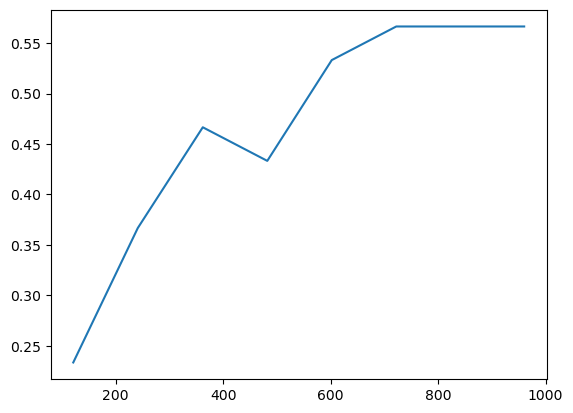

In [63]:
import matplotlib.pyplot as plt
results[results['classification/accuracy'].notnull()]['classification/accuracy'].plot()

# TRAIN AUGMENTED

In [13]:
# leave out 20% of the data for testing
from sklearn.model_selection import train_test_split

# only keep sentence and score columns

train, test = train_test_split(train_augmented, test_size=0.2, random_state=23, stratify=train_augmented['Score'])

class_counts_train = train['Score'].value_counts()
class_counts_test = test['Score'].value_counts()
# Print the counts
print(class_counts_train)
print(class_counts_test)

 0.0    108
-1.0     79
 0.5     70
 1.0     62
-0.5     41
Name: Score, dtype: int64
 0.0    27
-1.0    20
 0.5    17
 1.0    16
-0.5    10
Name: Score, dtype: int64


In [14]:
def preprocess(df):
    new_df = pd.DataFrame(columns=['prompt', 'completion'])
    new_df['prompt'] = df['Sentence'].apply(lambda x: 'Given the following sentence, analyze the sentiment and assign a score. The sentiment score should range from 0 to 4, where 0 indicates extremely negative sentiment, 1 indicates negative sentiment, 2 indicates neutral sentiment, 3 indicates positive sentiment, and 4 indicates extremely positive sentiment. ' + x + ' ->')
    score_mapping = {-1: 0, -0.5: 1, 0: 2, 0.5: 3, 1: 4}
    # map the scores to labels
    new_df['completion'] = df['Score'].map(score_mapping)
    # append space to the beginning of the completion
    new_df['completion'] = new_df['completion'].apply(lambda x: ' ' + str(x))    

    return new_df

In [15]:
train_new = preprocess(train)
test_new = preprocess(test)

In [16]:
train_gpt_new, test_gpt_new = train_test_split(train_new, test_size=0.2, random_state=23, stratify=train_new['completion'])

In [17]:
# save train and test data to jsonl files
train_gpt_new.to_json('train_gpt_new_at.jsonl', orient='records', lines=True)
test_gpt_new.to_json('test_gpt_new_at.jsonl', orient='records', lines=True)

In [20]:
# create fine tunes model
!openai api fine_tunes.create -t "train_gpt_new_at.jsonl" -v "test_gpt_new_at.jsonl" --compute_classification_metrics --classification_n_classes 5 -m ada --n_epochs 8 --suffix "nlp_prod_ada"

Uploaded file from train_gpt_new_at.jsonl: file-E0anZl7Y5325NZ07fcbTzYkL
Uploaded file from test_gpt_new_at.jsonl: file-gFQMrDAnnfaHMmHGV02wRgK9
Created fine-tune: ft-9dRrQZjRHe2BCVhHfGRhCucK
Streaming events until fine-tuning is complete...

(Ctrl-C will interrupt the stream, but not cancel the fine-tune)
[2023-06-05 21:41:43] Created fine-tune: ft-9dRrQZjRHe2BCVhHfGRhCucK

Stream interrupted (client disconnected).
To resume the stream, run:

  openai api fine_tunes.follow -i ft-9dRrQZjRHe2BCVhHfGRhCucK




Upload progress:   0%|          | 0.00/159k [00:00<?, ?it/s]
Upload progress: 100%|██████████| 159k/159k [00:00<?, ?it/s]

Upload progress:   0%|          | 0.00/38.0k [00:00<?, ?it/s]
Upload progress: 100%|██████████| 38.0k/38.0k [00:00<?, ?it/s]


In [25]:
!openai api fine_tunes.follow -i ft-9dRrQZjRHe2BCVhHfGRhCucK

[2023-06-05 21:41:43] Created fine-tune: ft-9dRrQZjRHe2BCVhHfGRhCucK
[2023-06-05 21:43:41] Fine-tune costs $0.09
[2023-06-05 21:43:42] Fine-tune enqueued. Queue number: 0
[2023-06-05 21:53:43] Fine-tune started
[2023-06-05 21:54:45] Completed epoch 1/8
[2023-06-05 21:55:33] Completed epoch 2/8
[2023-06-05 21:56:20] Completed epoch 3/8
[2023-06-05 21:57:06] Completed epoch 4/8
[2023-06-05 21:57:52] Completed epoch 5/8
[2023-06-05 21:58:39] Completed epoch 6/8
[2023-06-05 21:59:26] Completed epoch 7/8
[2023-06-05 22:00:12] Completed epoch 8/8
[2023-06-05 22:00:40] Uploaded model: ada:ft-personal:nlp-prod-ada-2023-06-05-14-00-39
[2023-06-05 22:00:41] Uploaded result file: file-WLgeXKKfsEra7imb9vIRGWyD
[2023-06-05 22:00:41] Fine-tune succeeded

Job complete! Status: succeeded 🎉
Try out your fine-tuned model:

openai api completions.create -m ada:ft-personal:nlp-prod-ada-2023-06-05-14-00-39 -p <YOUR_PROMPT>


In [26]:
# save results to csv
!openai api fine_tunes.results -i ft-9dRrQZjRHe2BCVhHfGRhCucK > result.csv

In [27]:
results = pd.read_csv('result.csv')
results[results['classification/accuracy'].notnull()]

,step,elapsed_tokens,elapsed_examples,training_loss,training_sequence_accuracy,training_token_accuracy,validation_loss,validation_sequence_accuracy,validation_token_accuracy,classification/accuracy,classification/weighted_f1_score
288,289,28097,289,0.022610,1.0,1.0,0.028064,1.0,1.0,0.416667,0.355336
576,577,56105,577,0.018040,1.0,1.0,0.016267,1.0,1.0,0.722222,0.721041
865,866,84210,866,0.018978,1.0,1.0,NaN,NaN,NaN,0.777778,0.777825
1154,1155,112291,1155,0.004636,1.0,1.0,NaN,NaN,NaN,0.875000,0.877833
1443,1444,140396,1444,0.009210,1.0,1.0,NaN,NaN,NaN,0.847222,0.844889
1731,1732,168540,1732,0.007871,1.0,1.0,NaN,NaN,NaN,0.916667,0.916672
2021,2022,196558,2022,0.003779,1.0,1.0,NaN,NaN,NaN,0.902778,0.903831
2304,2305,224201,2305,0.007867,1.0,1.0,0.009680,1.0,1.0,0.888889,0.890314


<AxesSubplot: >

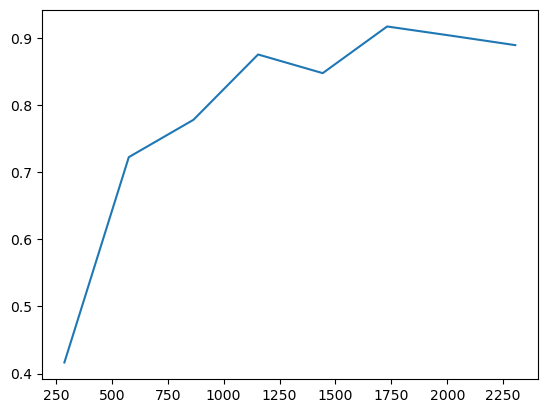

In [28]:
import matplotlib.pyplot as plt
results[results['classification/accuracy'].notnull()]['classification/accuracy'].plot()